<a href="https://colab.research.google.com/github/AndresSamboni/Book_Examples/blob/main/Example_2_DQN_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <FONT COLOR='darkgreen'>***EXAMPLE 2 – DQN AGENT***<FONT/>

---

Building the custom environment

---



In [ ]:
import gym
from gym import spaces
import numpy as np
from random import randint

# CLASS FOR CUSTOM ENVIRONMENT
class VNFEnvironment(gym.Env):
    # CONSTRUCTOR
    def __init__(self, num_CPU=8, num_RAM=12):
        super(VNFEnvironment, self).__init__()
        self.current_step = 0  # INITIATION OF THE FIRST STEP
        self.max_step = 100  # MAXIMUM NUMBER OF STEPS

        # I CALCULATE 10% OF THE PARAMETERS
        self.cpu_10 = (num_CPU * 10) // 100
        self.ram_10 = (num_RAM * 10) // 100
        if (self.cpu_10 == 0):
          self.cpu_10 = 1
        if (self.ram_10 == 0):
          self.ram_10 = 1

        # I SET THE MINIMUM STARTUP VALUES
        self.min_CPU_init = ((num_CPU * 10) // 100) + 1
        self.min_RAM_init = ((num_RAM * 10) // 100) + 1

        # I SET THE MAXIMUM VALUES AND THE MAXIMUM START VALUES
        self.max_CPU = num_CPU
        self.max_RAM = num_RAM
        self.max_CPU_init = ((num_CPU * 80) // 100) + 1
        self.max_RAM_init = ((num_RAM * 80) // 100) + 1

        # I SET THE INITIAL VALUES
        self.num_CPU = randint(self.min_CPU_init, self.max_CPU_init)  # NUMBER OF INITIAL CPU CORE(S)
        self.num_RAM = randint(self.min_RAM_init, self.max_RAM_init)  # AMOUNT OF INITIAL GB OF RAM

        # I IDENTIFY THE SPACE OF STATES
        self.state_size = 7  # ACTIONS: 0. KEEP BOTH. 1. INCREASE BOTH. 2. DECREASE BOTH.
                            # ACTIONS: 3. MAINTAIN RAM AND INCREASE CPU 4. MAINTAIN RAM AND DECREASE CPU.
                            # ACTIONS: 5. MAINTAIN CPU AND INCREASE RAM. 6. MAINTAIN CPU AND DECREASE RAM.
        self.action_space = spaces.Discrete(self.state_size)

        # DEFINE THE OBSERVATION SPACE
        self.observation_space = spaces.Box(
            low=np.array([0, 0]),
            high=np.array([self.max_CPU, self.max_RAM]),
            dtype=np.int32
        )

        # CREATION OF CPU AND RAM USAGE DICTIONARIES
        self.use_CPU = {
            10: (num_CPU * 10) // 100,
            20: (num_CPU * 20) // 100,
            30: (num_CPU * 30) // 100,
            40: (num_CPU * 40) // 100,
            50: (num_CPU * 50) // 100,
            60: (num_CPU * 60) // 100,
            70: (num_CPU * 70) // 100,
            80: (num_CPU * 80) // 100,
            90: (num_CPU * 90) // 100,
            100: num_CPU
        }
        self.use_RAM = {
            10: (num_RAM * 10) // 100,
            20: (num_RAM * 20) // 100,
            30: (num_RAM * 30) // 100,
            40: (num_RAM * 40) // 100,
            50: (num_RAM * 50) // 100,
            60: (num_RAM * 60) // 100,
            70: (num_RAM * 70) // 100,
            80: (num_RAM * 80) // 100,
            90: (num_RAM * 90) // 100,
            100: num_RAM
        }

        # INITIALIZE ACCUMULATED REWARDS
        self.total_reward = 0
        self.reward_CPU = 0
        self.reward_RAM = 0

    # RESET FUNCTION
    def reset(self):
        self.current_step = 0  # INITIATION OF THE FIRST STEP
        self.num_CPU = randint(self.min_CPU_init, self.max_CPU_init)  # NUMBER OF INITIAL CPU CORE(S)
        self.num_RAM = randint(self.min_RAM_init, self.max_RAM_init)  # AMOUNT OF INITIAL GB OF RAM
        # RESET REWARD VALUES
        self.total_reward = 0
        self.reward_CPU = 0
        self.reward_RAM = 0
        return self._get_state()

    def _get_state(self):
        return np.array([self.num_CPU, self.num_RAM])

    # FUNCTION FOR STEP ACTIONS
    def step(self, action):
        self.current_step += 1

        # REACTIONS TO THE AGENT'S ACTIONS
        if action == 0: #0. KEEP BOTH
            pass
        elif action == 1: #1. INCREASE BOTH
            self.num_CPU = min(self.num_CPU + self.cpu_10, self.max_CPU)
            self.num_RAM = min(self.num_RAM + self.ram_10, self.max_RAM)
        elif action == 2: #2. DECREASE BOTH
            self.num_CPU = max(self.num_CPU - self.cpu_10, 0)
            self.num_RAM = max(self.num_RAM - self.ram_10, 0)
        elif action == 3: #3. KEEP RAM AND BOOST CPU
            self.num_CPU = min(self.num_CPU + self.cpu_10, self.max_CPU)
        elif action == 4: #4. KEEP RAM AND DECREASE CPU
            self.num_CPU = max(self.num_CPU - self.cpu_10, 0)
        elif action == 5: #5. MAINTAIN CPU AND INCREASE RAM
            self.num_RAM = min(self.num_RAM + self.ram_10, self.max_RAM)
        elif action == 6: #6. KEEP CPU AND DECREASE RAM
            self.num_RAM = max(self.num_RAM - self.ram_10, 0)

        # REWARD CALCULATION
        reward, cpu_reward, ram_reward = self._calculate_reward()

        # UPDATE ACCUMULATED REWARDS
        self.total_reward += reward
        self.reward_CPU = cpu_reward
        self.reward_RAM = ram_reward

        # CHECK IF I FINISHED THE EPISODE
        done = self._check_done()

        # GET CURRENT STATUS
        state = self._get_state()

        return state, reward, done, {}

    # FUNCTION FOR REWARD CALCULATION
    def _calculate_reward(self):
        cpu_reward = 0
        ram_reward = 0

       # I CALCULATE THE REWARD FOR THE CPU
        if self.num_CPU <= self.use_CPU[10] or self.num_CPU >= self.use_CPU[80]:
            cpu_reward = -50
        elif self.use_CPU[10] < self.num_CPU < self.use_CPU[70]:
            cpu_reward = -1
        elif self.use_CPU[70] < self.num_CPU < self.use_CPU[80]:
            cpu_reward = -1
        elif self.num_CPU == self.use_CPU[70]:
            cpu_reward = 50

        # I CALCULATE THE RECOMPENSATION FOR THE RAM
        if self.num_RAM <= self.use_RAM[10] or self.num_RAM >= self.use_RAM[80]:
            ram_reward = -50
        elif self.use_RAM[10] < self.num_RAM < self.use_RAM[70]:
            ram_reward = -1
        elif self.use_RAM[70] < self.num_RAM < self.use_RAM[80]:
            ram_reward = -1
        elif self.num_RAM == self.use_RAM[70]:
            ram_reward = 50

        total_reward = cpu_reward + ram_reward
        return total_reward, cpu_reward, ram_reward

    # FUNCTION TO CHECK IF THE EPISODE ENDS
    def _check_done(self):
        if self.current_step >= self.max_step:
            return True
        if self.reward_CPU <= -50:
            return True
        if self.reward_RAM <= -50:
            return True
        if self.reward_CPU <= -50 and self.reward_RAM <= -50:
            return True
        if self.reward_CPU == 50 and self.reward_RAM == 50:
            return True
        return False

---

Deep Reinforcement Leaarning **( DRL )** agent.

---


In [ ]:
import random
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from collections import deque

# CREATION OF THE DQNAgent CLASS
class DQNAgent:
  # CONSTRUCTOR
  def __init__(self, state_size, action_size):
    # PARAMS INITIALIZE
    self.state_size = state_size
    self.action_size = action_size

    # MEMORY SIZE
    self.memory = deque(maxlen=5000)

    # AGENT PARAMETERS
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.learning_rate = 0.001

    # CREATE MODELS TO TRAIN WITH NN
    self.model = self._build_model()
    self.target_model = self._build_model()
    self.update_target_model()

  # BUILD THE NN MODEL
  def _build_model(self):
    # CREATION OF THE NN
    model = models.Sequential()
    # INPUT LAYER BY THE SPACE STATES IN THE ENVIRONMENT
    model.add(layers.Input(shape=(self.state_size,)))
    # HIDDEN LAYERS FULLY CONNECTED
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    # OUTPUT LAYER BY THE SPACE ACTIONS IN THE ENVIRONMENT <-- OBTAIN Q-VALUES
    model.add(layers.Dense(self.action_size))
    # MODEL CONFIGURATIONS
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
    return model

  # UPDATE TARGET MODEL
  def update_target_model(self):
    # UPDATING LEARNED WEIGHTS FOR MORE STABLE PREDICTIONS
    self.target_model.set_weights(self.model.get_weights())

  # REMEMBER FUNCTION
  def remember(self, state, action, reward, next_state, done):
    # SAVE EXPERIENCES IN MEMORY
    self.memory.append((state, action, reward, next_state, done))

  # SELECTED ACTIONS FUNCTION
  def act(self, state):
    # STOCK SELECTION BASED ON THE epsilon-greedy POLICY
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action_size) # EXPLORATION
    else:
      act_values = self.model.predict(state, verbose=0) # EXPLOTATION
      return np.argmax(act_values[0])

  # REPLAY FUNCTION
  def replay(self, batch_size):
    # SAMPLE BATCH
    minibatch = random.sample(self.memory, batch_size)
    # OBTAIN THE PARAMETERS OF THE SAMPLE BATCH
    states = np.vstack([x[0] for x in minibatch])
    actions = np.array([x[1] for x in minibatch])
    rewards = np.array([x[2] for x in minibatch])
    next_states = np.vstack([x[3] for x in minibatch])
    dones = np.array([x[4] for x in minibatch])
    # PREDICT THE TARGETS AND NEXT TARGETS
    targets = self.model.predict(states, verbose=0)
    target_next = self.target_model.predict(next_states, verbose=0)
    # TRAIN THE NN MODEL WITH THE LEARNED Q-VALUES
    for i in range(batch_size):
      if dones[i]:
        targets[i][actions[i]] = rewards[i]
      else:
        targets[i][actions[i]] = rewards[i] + self.gamma * np.amax(target_next[i])
    self.model.fit(states, targets, epochs=1, verbose=0)

  # UPDATE EPSILON FUNCTION
  def update_epsilon(self):
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

---

Deep Reinforcement Learning **( DRL )** agent training.

---

In [ ]:
# ENVIRONMENT INITIALIZE
env = VNFEnvironment()
# GET SCENCIAL PARAMETERS OF THE ENVIRONMENT
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# AGENT INITIALIZE
agent = DQNAgent(state_size, action_size)
# TRAINING PARAMETERS
batch_size = 64
episodes = 1000
# LIST FOR ACCUMULATED REWARD
rewards_per_episode = []
# TRAINING LOOP
for e in range(episodes):
  # RESET PARAMETERS PER EPISODE
  state = env.reset()
  state = np.reshape(state, [1, state_size])
  total_reward = 0
  done = False
  # FINALIZATION EPISODE LOOP
  while not done:
    # SELECT ACTION
    action = agent.act(state)
    # EXECUTE ACTION
    next_state, reward, done, _ = env.step(action)
    # SAVE REWARD
    total_reward += reward
    # UPDATE NEXT STATE
    next_state = np.reshape(next_state, [1, state_size])
    # SAVE EXPERIENCE IN MEMORY
    agent.remember(state, action, reward, next_state, done)
    # UPDATE THE CURRENT STATE
    state = next_state
    # CHECK IF THE EPISODE IS FINISHED
    if done:
      # UPDATE THE TARGET MODEL
      agent.update_target_model()
      print(f'\nEpisode {e}/{episodes}: Total reward = {total_reward}\nEpisode {e}/{episodes}: Epsilon = {agent.epsilon:.4f}')
      # SAVE REWARD PER EPISODE
      rewards_per_episode.append(total_reward)
      break
    # TRAIN THE NN MODEL OF THE AGENT
    if len(agent.memory) > batch_size:
      agent.replay(batch_size)
  # UPDATE EPSILON VALUE PER EPISODE
  agent.update_epsilon()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Episode 0/1000: Total reward = -100
Episode 0/1000: Epsilon = 1.0000

Episode 1/1000: Total reward = -118
Episode 1/1000: Epsilon = 0.9950

Episode 2/1000: Total reward = 0
Episode 2/1000: Epsilon = 0.9900

Episode 3/1000: Total reward = -51
Episode 3/1000: Epsilon = 0.9851

Episode 4/1000: Total reward = -51
Episode 4/1000: Epsilon = 0.9801

Episode 5/1000: Total reward = 47
Episode 5/1000: Epsilon = 0.9752

Episode 6/1000: Total reward = -51
Episode 6/1000: Epsilon = 0.9704

Episode 7/1000: Total reward = -100
Episode 7/1000: Epsilon = 0.9655

Episode 8/1000: Total reward = -51
Episode 8/1000: Epsilon = 0.9607

Episode 9/1000: Total reward = -100
Episode 9/1000: Epsilon = 0.9559

Episode 10/1000: Total reward = -119
Episode 10/1000: Epsilon = 0.9511

Episode 11/1000: Total reward = -79
Episode 11/1000: Epsilon = 0.9464

Episode 12/1000: Total reward = -2
Episode 12/1000: Epsilon = 0.9416

Episode 13/1000: Total reward = 0
Episode 13/1000: Epsilon = 0.9369

Episode 14/1000: Total rew

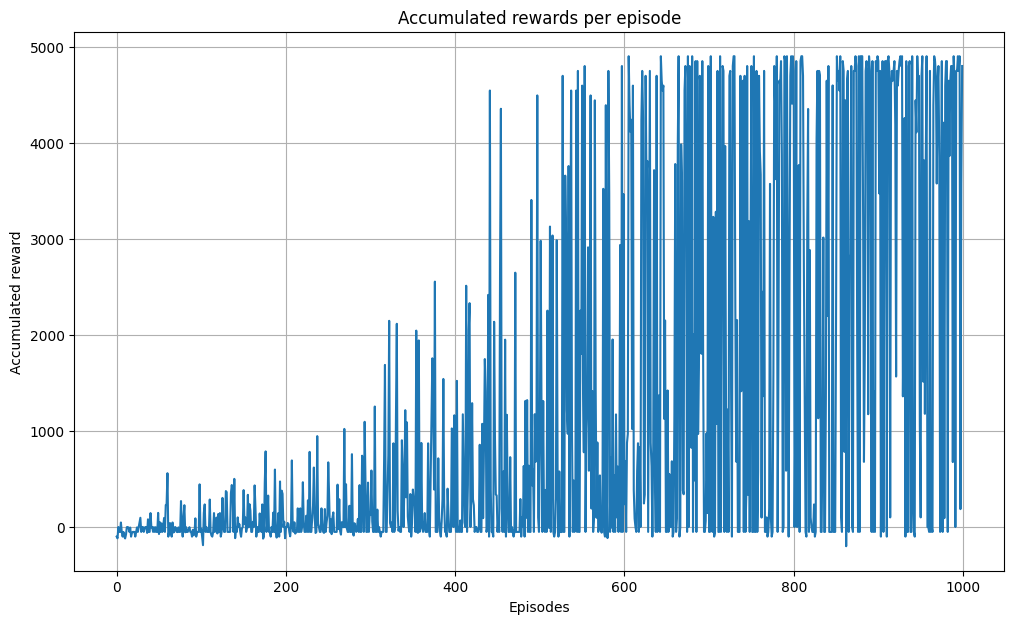

In [ ]:
# LIBRARY TO CREATE GRAPHICS
import matplotlib.pyplot as plt

# GRAPH FOR ACCUMULATED REWARD PER EPISODE
plt.figure(figsize=(12,7))
plt.plot(rewards_per_episode, label='LEARNING PERFORMANCE')
plt.xlabel('Episodes')
plt.ylabel('Accumulated reward')
plt.title('Accumulated rewards per episode')
plt.grid(True)
plt.show()

---

**DRL** agent evaluation.

---

In [ ]:
# TEST PARAMETERS
test_episodes = 200
test_rewards = []
cpu_usage_final_per_test_episode = []
ram_usage_final_per_test_episode = []
# TEST PREDICT LOOP
for e in range(test_episodes):
  # RESET PARAMETERS PER EPISODE
  state = env.reset()
  state = np.reshape(state, [1, state_size])
  total_reward = 0
  done = False
  # FINALIZATION EPISODE LOOP
  while not done:
    # SELECT ACTION
    action = np.argmax(agent.model.predict(state, verbose=0))
    # EXECUTE ACTION
    next_state, reward, done, _ = env.step(action)
    # SAVE REWARD
    total_reward += reward
    # UPDATE CURRENT STATE
    state = np.reshape(next_state, [1, state_size])
  # SAVE REWARDS PER EPISODE
  test_rewards.append(total_reward)
  cpu_usage_final_per_test_episode.append(env.num_CPU)
  ram_usage_final_per_test_episode.append(env.num_RAM)
# OBTAIN THE AVERAGE TEST REWARD
avg_test_reward = np.mean(test_rewards)
print(f'Average reward in {test_episodes} test episodes: {avg_test_reward}')

Average reward in 200 test episodes: 3182.795


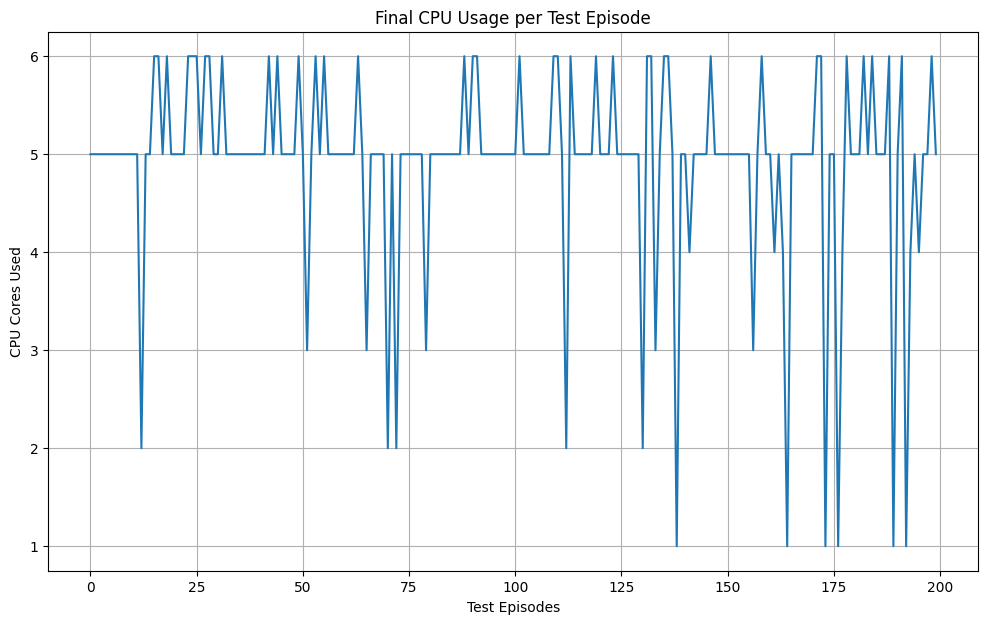

In [ ]:
# CHART FOR CPU PERFORMANCE
plt.figure(figsize = (12,7))
plt.plot(cpu_usage_final_per_test_episode, label='CPU Usage')
plt.xlabel('Test Episodes')
plt.ylabel('CPU Cores Used')
plt.title('Final CPU Usage per Test Episode')
plt.grid(True)
plt.show()

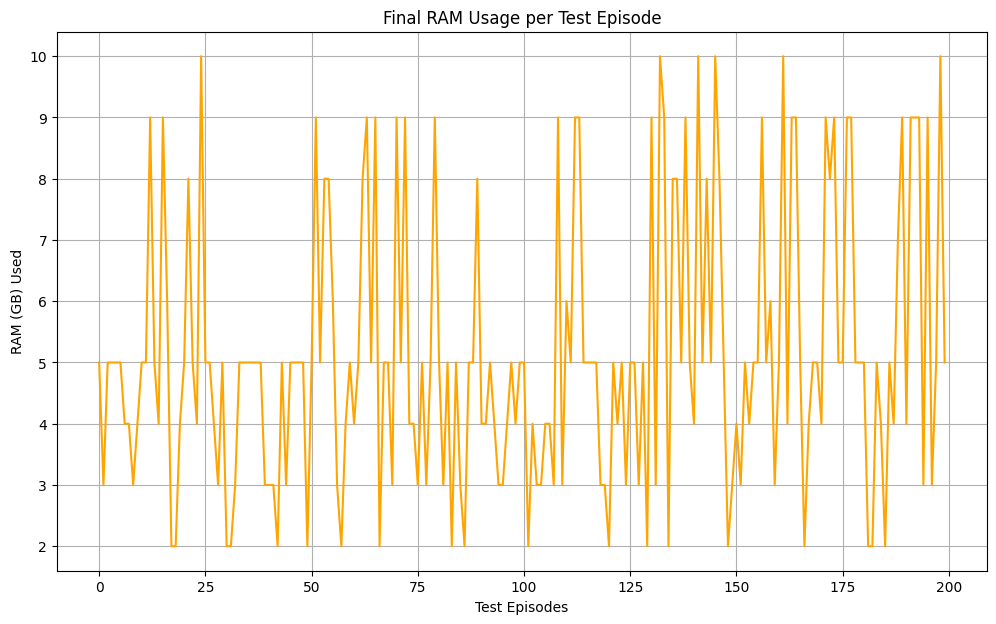

In [ ]:
# CHART FOR RAM PERFORMANCE
plt.figure(figsize = (12,7))
plt.plot(ram_usage_final_per_test_episode, label='RAM Usage', color='orange')
plt.xlabel('Test Episodes')
plt.ylabel('RAM (GB) Used')
plt.title('Final RAM Usage per Test Episode')
plt.grid(True)
plt.show()